# scRNAseq

Heatmap of transcript levels (CPM) of inducible macrophage genes (Bhatt et al., 2012) detected by scRNA-seq.

In [1]:
ENV["Code"] = "../../Code"
for folder in readdir(ENV["Code"]); push!(LOAD_PATH, normpath(ENV["Code"], folder));end

using Seaborn, PyPlot, PyCall, DataFrames
using NoLongerProblems_Pandas, Pandas
using MultipleTesting, HypothesisTests 
using SingleCellExperiment
using CSV, ProgressMeter,PrettyPlotting, ScikitLearn
@sk_import linear_model: LogisticRegression

include("../Databases/Cuartero2018.jl")
include("../Databases/Bhatt2012.jl")
include("../Databases/MF_SingleCell.jl")
include("../Code/Load_scRNAseqData.jl")

sce = SingleCellExperiment.get_cells_with_this_characteristics(["WT"], :Genotype, sce)
sce = SingleCellExperiment.fit_mu_std_alpha(sce, splitdataby = :Sample, assay = "CPM")
sce = SingleCellExperiment.fit_single_cell_logistic_regression(sce, assay = "CPM")
bhattgenes = Bhatt2012.inducible_genes_figure3()[!,:GeneSymbol];
sce = SingleCellExperiment.Shalek2014_module_score(collect(bhattgenes), sce,fitparameter = "mu", modulescore_name = :BhattGenesScore, untreated_pattern = "UT",comparedtothissample = "WT", assay = "CPM")
sce = SingleCellExperiment.fit_mu_std_alpha(sce, splitdataby = :Sample, assay = "lnCPMplus1")

bhattgenes= DataFrames.DataFrame(
    "GeneID" => Bhatt2012.inducible_genes_figure3()[!,:GeneSymbol], 
    "Class"=>Bhatt2012.inducible_genes_figure3()[!,:Class]
    );
sceBhatt = innerjoin(sce.rowData, bhattgenes,on = :GeneID)

col_colors_dict = Dict(
    "WT_UT" => "#f0f0f0",
    "WT_2H" => "#bdbdbd",
    "WT_8H" => "#636363",
    "RAD21_UT" => "#fee0d2",
    "RAD21_2H" => "#fc9272",
    "RAD21_8H" => "#de2d26",
    "RAD21" => "red",
    "WT" => "darkgrey",
    "0" => "#deebf7",
    "2" => "#9ecae1",
    "8" => "#3182bd",
    ) 

┌ Info: Precompiling SingleCellExperiment [4f094565-8285-4053-8640-d916605c3f41]
└ @ Base loading.jl:1342
Progress: 100%|█████████████████████████████████████████| Time: 0:00:21


Dict{String, String} with 11 entries:
  "2"        => "#9ecae1"
  "WT"       => "darkgrey"
  "RAD21_2H" => "#fc9272"
  "8"        => "#3182bd"
  "RAD21_UT" => "#fee0d2"
  "RAD21_8H" => "#de2d26"
  "0"        => "#deebf7"
  "WT_UT"    => "#f0f0f0"
  "RAD21"    => "red"
  "WT_8H"    => "#636363"
  "WT_2H"    => "#bdbdbd"

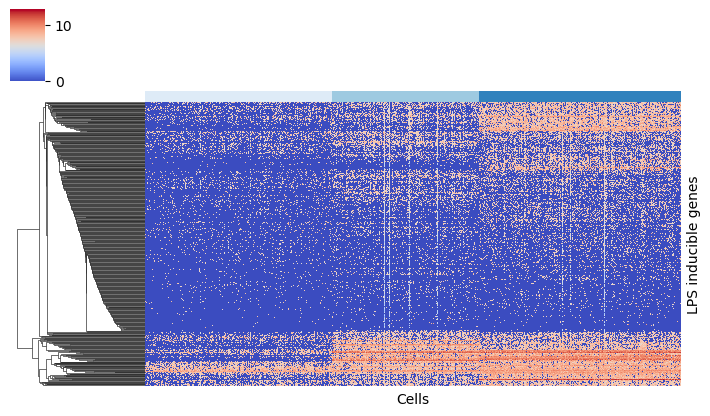

/Users/irr15/.julia/conda/3/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


In [2]:
sce.colData[!,"LPS"] = [replace(replace(replace(split(ii, "_")[2], "UT" => 0), "2H" => 2), "8H" => 8) for ii in sce.colData[!,"Sample"]]
sce = sort_cells!(sce, cols = [ :LPS, :Genotype,:BhattGenesScore], rev = [false, true, false])
subsce = select_these_genes(bhattgenes[!,:GeneID], sce)

g = Seaborn.clustermap(subsce.assays["lnCPMplus1"], figsize = (7, 4),yticklabels=false,xticklabels=false, col_cluster = false, col_colors = [col_colors_dict[ii] for ii in subsce.colData[!,:LPS]], cmap="coolwarm")

ax = g.ax_heatmap
ax.set_ylabel("LPS inducible genes")
ax.set_xlabel("Cells")
ax.tick_params(axis="both", which="both", length=0)

savefigwithtext("scRNAseq_heatmap_bhattgenes_WT.pdf")

In [ ]:
import Pkg
Pkf.status()